<a href="https://colab.research.google.com/github/suwisitlk/229351-StatisticalLearning/blob/main/229351_LAB10_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-11 02:28:55--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.04s   

2025-09-11 02:28:55 (3.30 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [3]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [4]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [5]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [12]:
#แบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set
train = data_monthly[:-24]
test = data_monthly[-24:]
print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64


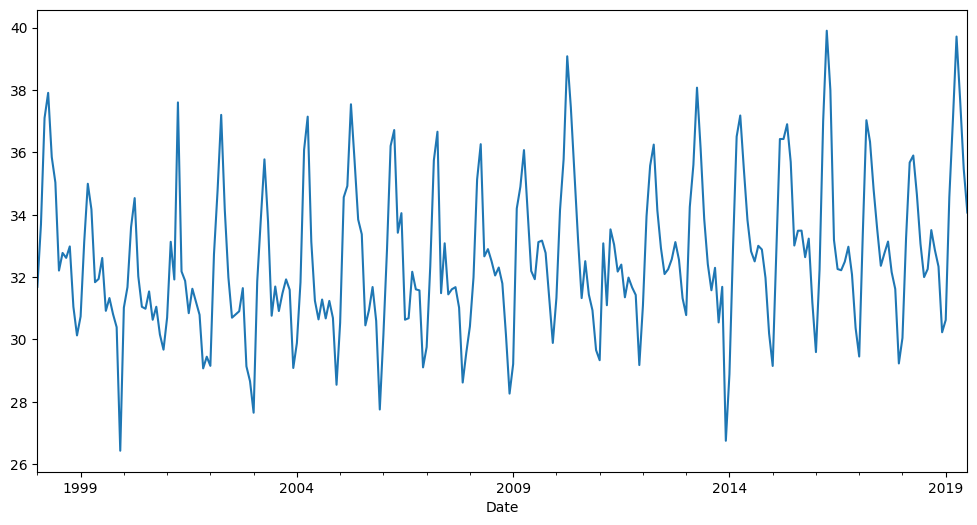

In [8]:
plt.figure(figsize=(12,6))
data_monthly.plot();

In [ ]:
สร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=False,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-1277562403.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


RMSE: 2.697261490836458


In [19]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=True,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.7206000811236914


/tmp/ipython-input-679810685.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


In [20]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=False,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-516674200.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


RMSE: 1.1669523392712184


In [21]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.1639766564724707


/tmp/ipython-input-2173339229.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


In [14]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped=False,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 3.2472538878024


/tmp/ipython-input-2712172477.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


In [18]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped=True,
                          seasonal=None,
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 2.7206000811236675


/tmp/ipython-input-3248715282.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


In [25]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped=False,
                          seasonal='add',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-1283289815.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


RMSE: 1.1875960299599877


In [23]:
es = ExponentialSmoothing(train,
                          trend = 'mul',
                          damped=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

/tmp/ipython-input-2271426166.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


RMSE: 1.182446316454671


พบว่าแบบที่ทำให้ค่า RMSE ต่ำสุดคือโมเดล


In [28]:
es = ExponentialSmoothing(train,
                          trend = 'add',
                          damped=False,
                          seasonal='mul',
                          seasonal_periods=12)
es_fit = es.fit(optimized=True)
yhat = es_fit.predict('2017-08-31', '2019-07-31')

print('RMSE:',rmse(test,yhat))

RMSE: 1.1639766564724707


/tmp/ipython-input-1022933126.py:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  es = ExponentialSmoothing(train,


จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

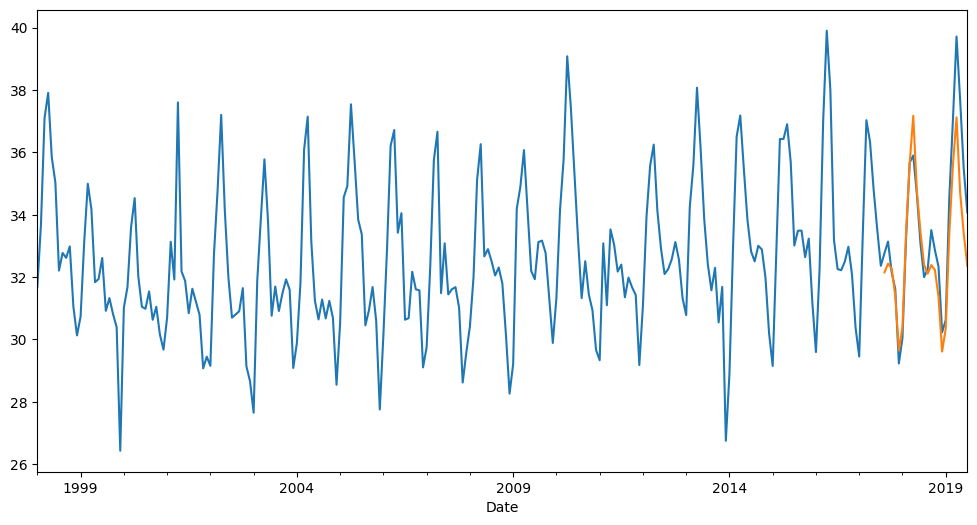

In [29]:
plt.figure(figsize=(12,6))
data_monthly.plot()
yhat.plot();